# 1 Load the function which is used to create df_paper and df_relationship

## 1.1 Import libraries

In [153]:
#encoding:utf-8
import pandas as pd 
from pandas import Series, DataFrame
import MySQLdb
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("whitegrid")

## 1.2 Define some functions used to get some dataframes from mysql 

In [4]:
def get_paper(conn):
	sql_paper = "SELECT paper_id, paper_title, paper_publicationYear, paper_nbCitation, paper_label, venue_venue_id FROM paper"
	df_paper = pd.read_sql(sql_paper, conn)
	return df_paper

def get_a2p(conn):
	sql_a2p = "SELECT * FROM a2p"
	df_a2p = pd.read_sql(sql_a2p, conn)
	return df_a2p

def get_author(conn):
	sql_author = "SELECT * FROM author"
	df_author = pd.read_sql(sql_author, conn)
	return df_author

def get_relationship(conn):
	sql_relationship = "SELECT relationship_src, relationship_dst FROM relationship"
	df_relationship = pd.read_sql(sql_relationship, conn)
	return df_relationship

def get_venue(conn):
	sql_venue = "SELECT * FROM venue"
	df_venue = pd.read_sql(sql_venue, conn)
	return df_venue

def get_dblp2ccf(conn):
	sql_dblp2ccf = "SELECT * FROM dblp2ccf"
	df_dblp2ccf = pd.read_sql(sql_dblp2ccf, conn)
	return df_dblp2ccf

def get_ccf(conn):
	sql_ccf = "SELECT * FROM ccf"
	df_ccf = pd.read_sql(sql_ccf, conn)
	return df_ccf

## 1.3 Define function to get df_paper and df_relationship

In [5]:
def generate_relationship(sql_ip, port, user, passwd, db):
	#根据数据库信息， 返回df_relationship，其中包含源和目的的发表年份、标签、最大H因子、第一作者所属国家

	conn = MySQLdb.connect(host=sql_ip, user=user, port=port, passwd=passwd, db=db, charset='utf8')

	df_paper = get_paper(conn)
	df_a2p = get_a2p(conn)
	df_author = get_author(conn)
	df_relationship = get_relationship(conn)
	df_venue = get_venue(conn)
	df_dblp2ccf = get_dblp2ccf(conn)
	df_ccf = get_ccf(conn)
	
	
	#*********************************************此部分得到论文的最大H因子********************************************************
	#合并, 内连接为了得到每个论文作者的最大H因子
	df = pd.merge(df_paper, pd.merge(df_author, df_a2p, left_on='author_id', right_on='author_author_id'), left_on='paper_id', right_on='paper_paper_id')

	#查看df的列名
	#df.columns

	#按paper_id分组
	group_paper = df.groupby(df['paper_id'])
	#得到paper的最大H因子
	res_Hindex = group_paper.author_H_Index.max()
	#计数，得到最大H因子的个数
	#res = res_Hindex.value_counts()

	#找到作者最大H因子，写到df_paper中
	df_Hindex = DataFrame(res_Hindex)
	df_Hindex['paper_id'] = df_Hindex.index

	#*************************************此部分得到论文的J/C、computercategory***************************************************
	df2_part1 = pd.merge(df_paper, df_venue, left_on='venue_venue_id', right_on='venue_id')
	df2_part2 = pd.merge(df_ccf, df_dblp2ccf, left_on='CCF_id', right_on='ccf_CCF_id')
	df2_part2 = df2_part2[df2_part2['dblp_dblp_id']<999999999]
	df2 = pd.merge(df2_part1, df2_part2, left_on='dblp_dblp_id', right_on='dblp_dblp_id')
	df2 = df2[['paper_id', 'CCF_type', 'computercategory_computerCategory_id', 'CCF_id']] #加上论文的CCF_id
	df2 = df2.drop_duplicates(['paper_id']) #去掉重复的paper_id数据

	df_paper = pd.merge(df_paper, df_Hindex, left_on='paper_id', right_on='paper_id', how='outer') #在paper表上加上Max H因子
	df_paper = pd.merge(df_paper, df2, left_on='paper_id', right_on='paper_id', how='outer') #在paper表上加上J/C, computer类别

	#找到每篇论文第一作者的国籍，写入df_paper中
	df_sub = df[df['a2p_order']==1]
	df_sub2 = df_sub[['paper_id', 'author_affiliation_name']]
	df_sub_China = df_sub2[df_sub2['author_affiliation_name'].str.contains('China')].copy()
	df_sub_Australia = df_sub2[df_sub2['author_affiliation_name'].str.contains('Australia')].copy()

	df_sub_China['country'] = 'China'
	df_sub_Australia['country'] = 'Australia'
	df_country = pd.concat([df_sub_China, df_sub_Australia])
	df_country = df_country.drop_duplicates(['paper_id']) #去除2446篇第一作者来自两个国家的情况，这里将澳大利亚的情况去掉

	#df_paper_inter = pd.merge(df_paper, df_country) #只包括中国和澳大利亚作者
	df_paper_outer = pd.merge(df_paper, df_country, how = 'outer')#包括所有国家作者，但是大部分国籍为NAN(除中澳外的其他国家)

	df_relationship = pd.merge(df_relationship, df_paper_outer[['paper_id','paper_publicationYear','paper_label','author_H_Index', 'CCF_type', 'computercategory_computerCategory_id', 'country', 'CCF_id']], left_on='relationship_src', right_on='paper_id')
	del df_relationship['paper_id']
	#换列名
	df_relationship.columns = ['relationship_src', 'relationship_dst', 'relationship_src_publicationYear', 'relationship_src_label', 'relationship_src_maxHindex', 'relationship_src_type', 'relationship_src_computerCategory', 'relationship_src_country', 'relationship_src_ccfid']

	df_relationship = pd.merge(df_relationship, df_paper_outer[['paper_id','paper_publicationYear','paper_label','author_H_Index', 'CCF_type', 'computercategory_computerCategory_id', 'country', 'CCF_id']], left_on='relationship_dst', right_on='paper_id')
	del df_relationship['paper_id']
	df_relationship.columns = ['relationship_src', 'relationship_dst', 'relationship_src_publicationYear', 'relationship_src_label', 'relationship_src_maxHindex', 'relationship_src_type', 'relationship_src_computerCategory', 'relationship_src_country', 'relationship_src_ccfid', 'relationship_dst_publicationYear', 'relationship_dst_label', 'relationship_dst_maxHindex', 'relationship_dst_type', 'relationship_dst_computerCategory', 'relationship_dst_country', 'relationship_dst_ccfid']
	#此时的df_relationship包含源和目的的发表年份、标签、最大H因子、type、 CCF类别、第一作者所属国家

	return df_paper_outer, df_relationship

## 1.4 Load mysql parameters

In [6]:
#sql_ip = "shhr.online" #数据库地址
#port = 33755 #数据库端口号
#sql_ip = "192.168.1.198"
sql_ip = "127.0.0.1"
port = 3306
#user = "jingfei" #用户名
user = "root"
passwd = "hanjingfei007"
db = "aminer_gai"

## 1.5 Create DataFrames 

In [7]:
df_paper, df_relationship = generate_relationship(sql_ip, port, user, passwd, db)

df_paper's parameters include **paper_id, paper_title, paper_publicationYear, paper_nbCitation, paper_label, venue_venue_id, author_H_index, CCF_type, computercategory_computerCategory_id, CCF_id, author_affiliation_name, country**

In [8]:
df_paper.head() #原始的paper信息加上最大作者H因子、J/C、计算机类别、CCF id、作者名、第一作者国家

,paper_id,paper_title,paper_publicationYear,paper_nbCitation,paper_label,venue_venue_id,author_H_Index,CCF_type,computercategory_computerCategory_id,CCF_id,author_affiliation_name,country
0,1276,Computer algebra applications,2000,0,None,8292,6.0,NaN,NaN,NaN,NaN,NaN
1,2484,The development of computer science,2000,4,None,8293,3.0,NaN,NaN,NaN,NaN,NaN
2,3019,A query interface for IMAGE databases based on...,2000,0,None,8294,11.0,NaN,NaN,NaN,"Royal Melbourne Institute of Technology, Melbo...",Australia
3,3020,Quokka: a translator generator using denotatio...,2000,0,None,8294,2.0,NaN,NaN,NaN,"Univ. of New South Wales, Kensington, NSW, Aus...",Australia
4,3021,A clause indexing system for PROLOG based on s...,2000,0,None,8294,6.0,NaN,NaN,NaN,"Univ. of New South Wales, Sydney, Australia;Un...",Australia


df_relationship is used to show citation relationship. Its parameters include 

**relationship_src, relationship_dst**

**relationship_src_publicationYear, relationship_src_label, relationship_src_maxHindex, relationship_src_type, 
relationship_src_computerCategory, relationship_src_country, relationship_src_ccfid**

**relationship_dst_publicationYear, relationship_dst_label, relationship_dst_maxHindex, relationship_dst_type, 
relationship_dst_computerCategory, relationship_dst_country, relationship_dst_ccfid**

In [9]:
df_relationship.head()

,relationship_src,relationship_dst,relationship_src_publicationYear,relationship_src_label,relationship_src_maxHindex,relationship_src_type,relationship_src_computerCategory,relationship_src_country,relationship_src_ccfid,relationship_dst_publicationYear,relationship_dst_label,relationship_dst_maxHindex,relationship_dst_type,relationship_dst_computerCategory,relationship_dst_country,relationship_dst_ccfid
0,54484,54476,2000,None,3.0,NaN,NaN,NaN,NaN,2000,None,1.0,NaN,NaN,NaN,NaN
1,54476,54484,2000,None,1.0,NaN,NaN,NaN,NaN,2000,None,3.0,NaN,NaN,NaN,NaN
2,54573,54572,2000,None,20.0,NaN,NaN,NaN,NaN,2000,None,9.0,NaN,NaN,NaN,NaN
3,333245,179374,2001,None,28.0,NaN,NaN,NaN,NaN,2011,None,2.0,NaN,NaN,NaN,NaN
4,333964,179374,2001,None,49.0,NaN,NaN,NaN,NaN,2011,None,2.0,NaN,NaN,NaN,NaN


## 1.6 Preprocess

### 1.6.1 Drop the relationship bug

There are some bugs in our dataset. In there, we try to delete 32,151 items in table relationship whose destination publication year is smaller than its source publication year.

In [10]:
#df_relationship[df_relationship['relationship_src_publicationYear'] > df_relationship['relationship_dst_publicationYear']]
df_relationship = df_relationship[df_relationship['relationship_src_publicationYear'] <= df_relationship['relationship_dst_publicationYear']]

# 2 Data analysis for df_paper

## 2.1  Show the yearly number of publicationsfrom 2000 to 2014.

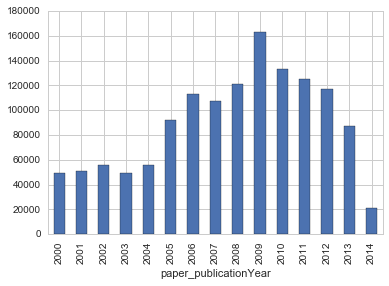

In [11]:
%matplotlib inline
df_paper.groupby(['paper_publicationYear'])['paper_id'].size().plot(kind='bar')

We can find that the number of publications grew at an exponential rate from 2000 to 2009. But decreased since 2010. This is different from other papers and intuition.

I think it's because our dataset is **incomplete**. So I think we can only use this dataset to reasearch the difference betweenCCF and CORE.

If we want to predict citation, we need to use the complete [Academic Social Networks](https://aminer.org/aminernetwork).

But I think we need to consider the latest citation data in AMiner -- [citation](https://aminer.org/citation). The data is only for citation research.

In the citation dataset, no author informations are considered. So I think we can use the data from 2000 to 2010.

## 2.2 Test if multiple authors receive more citations than solo-authored ones. [BY Wuchty](http://www.kellogg.northwestern.edu/faculty/uzzi/ftp/teams.printversion.pdf)

In [16]:
conn = MySQLdb.connect(host=sql_ip, user=user, port=port, passwd=passwd, db=db, charset='utf8')
df_a2p = get_a2p(conn)

In [17]:
df_a2p.head()

,a2p_id,a2p_order,author_author_id,paper_paper_id
0,2141,1,565329,1276
1,2142,2,518281,1276
2,4172,1,1708068,2484
3,5035,1,232108,3019
4,5036,2,39675,3019


In [20]:
grouped_paper = df_a2p.groupby('paper_paper_id')['author_author_id'].size()

In [22]:
grouped_paper.index

Int64Index([   1276,    2484,    3019,    3020,    3021,    3022,    3053,
               3054,    3055,    3056,
            ...
            2091249, 2091250, 2091251, 2092350, 2092351, 2092352, 2092353,
            2092354, 2092355, 2092356],
           dtype='int64', name=u'paper_paper_id', length=1305906)

In [36]:
df_cntAuthor = DataFrame(grouped_paper, columns=['cntAuthor'])

In [38]:
df_tmp = pd.merge(df_paper, df_cntAuthor, left_on='paper_id', right_index=True, how='left')

In [39]:
df_tmp.head()

,paper_id,paper_title,paper_publicationYear,paper_nbCitation,paper_label,venue_venue_id,author_H_Index,CCF_type,computercategory_computerCategory_id,CCF_id,author_affiliation_name,country,cntAuthor
0,1276,Computer algebra applications,2000,0,None,8292,6.0,NaN,NaN,NaN,NaN,NaN,2.0
1,2484,The development of computer science,2000,4,None,8293,3.0,NaN,NaN,NaN,NaN,NaN,1.0
2,3019,A query interface for IMAGE databases based on...,2000,0,None,8294,11.0,NaN,NaN,NaN,"Royal Melbourne Institute of Technology, Melbo...",Australia,2.0
3,3020,Quokka: a translator generator using denotatio...,2000,0,None,8294,2.0,NaN,NaN,NaN,"Univ. of New South Wales, Kensington, NSW, Aus...",Australia,1.0
4,3021,A clause indexing system for PROLOG based on s...,2000,0,None,8294,6.0,NaN,NaN,NaN,"Univ. of New South Wales, Sydney, Australia;Un...",Australia,2.0


In [90]:
li = range(10)
li.extend([200])
cut = pd.cut(df_tmp.cntAuthor, li)

In [91]:
cut.value_counts()

(1, 2]      387928
(2, 3]      347888
(0, 1]      207720
(3, 4]      203225
(4, 5]       88794
(5, 6]       37380
(6, 7]       15405
(7, 8]        7544
(9, 200]      6181
(8, 9]        3841
dtype: int64

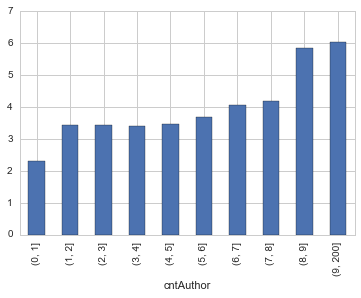

In [92]:
df_tmp.groupby(cut)['paper_nbCitation'].mean().plot(kind='bar')

## 2.3 Power-law distribution

### 2.3.1 Distribution of the number of all citations of papers.

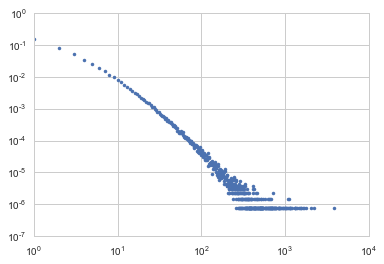

In [124]:
grouped = df_paper.groupby('paper_nbCitation')['paper_id'].size()
fre = grouped * 1.0/ grouped.sum()
plt.loglog(fre.index, fre.values, '.')

### 2.3.2 Distribution of the number of citations of papers received within 5 years after publication.

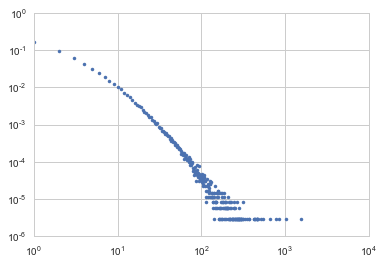

In [154]:
df_tmp = df_relationship[df_relationship['relationship_dst_publicationYear'] - df_relationship['relationship_src_publicationYear'] <= 5]

df_tmp = df_tmp[df_tmp['relationship_src_publicationYear'] <= 2005]

grouped = df_tmp.groupby('relationship_src')['relationship_dst'].size()

grouped = DataFrame(grouped, columns=['cnt_5years'])

df_paper_tmp = df_paper[df_paper['paper_publicationYear'] <= 2005]
df_merge = pd.merge(df_paper_tmp, grouped, left_on='paper_id', right_index=True, how='left')
df_merge['cnt_5years'] = df_merge['cnt_5years'].fillna(0)
grouped2 = df_merge.groupby('cnt_5years')['paper_id'].size()
fre = grouped2 * 1.0/ grouped2.sum()
plt.loglog(fre.index, fre.values, '.')